# The influence of weather on bike-sharing
## Sources of datasets:

[London weather data](https://www.kaggle.com/datasets/noahx1/london-weather-2000-2023)

[Bike-Share Usage in London and Taipei Network](https://www.kaggle.com/datasets/ajohrn/bikeshare-usage-in-london-and-taipei-network/data)

### Things to do to run:
* Download these three datasets: London.csv, London_stations.csv (source 2) & london0_23_weather_data.csv (source 1)
* Place the files together with this code in a shared folder

To run the code (in VSC):
* Make sure you have Python installed (I'm using Python 3.11.9)
* To the upper right here, select this Python as kernel
* It migh be that you still need to select an environment to run the code, use .venv
* In the cell below: uncomment the pip-commands (only run this once, then comment them again)
* It should work now :)

## Installing and defining names and files

In [1]:
#pip install pandas

In [2]:
#pip install seaborn

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#We only look at the London-data (there is also data from Taipei network)
df_london = pd.read_csv('london.csv', parse_dates=[3,6], infer_datetime_format=True)
df_london.shape

C:\Users\arthu\AppData\Local\Temp\ipykernel_23748\2391621177.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_london = pd.read_csv('london.csv', parse_dates=[3,6], infer_datetime_format=True)


(38215560, 9)

In [5]:
#import the names of the stations (a bit easier to identify stations later)
df_london_geo = pd.read_csv('london_stations.csv')


In [6]:
#import weather data of London (this goes from 2000-2023, so we can discard a lot later)
df_london_weather = pd.read_csv('london0_23_weather_data.csv')

#Since there is no explicit date column, I create one for our ease (starting from 01-01-2000):
df_london_weather['date'] = pd.date_range(start='2000-01-01', periods=len(df_london_weather), freq='D') 
# Extract useful time-related features
df_london_weather['day'] = df_london_weather['date'].dt.day
df_london_weather['month'] = df_london_weather['date'].dt.month
df_london_weather['week'] = df_london_weather['date'].dt.isocalendar().week
df_london_weather['dayofweek'] = df_london_weather['date'].dt.dayofweek
df_london_weather['year'] = df_london_weather['date'].dt.year
df_london_weather['satsun'] = df_london_weather['dayofweek'].map({0: False, 1: False, 2: False, 3: False, 4: False, 5: True, 6:True})

# Display the first few rows
df_london_weather.head(3)

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,date,day,month,week,dayofweek,year,satsun
0,7.3,3.1,9.0,1.8,NaN,NaN,2.3,NaN,1024.5,NaN,2000-01-01,1,1,52,5,2000,True
1,9.5,8.0,11.0,NaN,NaN,225.0,11.6,NaN,1025.2,NaN,2000-01-02,2,1,52,6,2000,True
2,9.4,5.6,11.2,2.0,NaN,233.0,16.8,NaN,1018.5,NaN,2000-01-03,3,1,1,0,2000,False


In [7]:
#The data includes rare rental events that are started but not ended. For this analysis these are best removed.
df_london = df_london.loc[~df_london.isnull().any(axis=1)]
df_london = df_london.astype({'bike_id' : 'int32', 'end_station_id' : 'int32', 'start_station_id' : 'int32'})
df_london.shape

(38147278, 9)

In [8]:
#Augment datetime data to make it easier for binning and applying conditions with respect to time.
df_london.loc[:, 'year'] = df_london['start_rental_date_time'].dt.year
df_london.loc[:, 'month'] = df_london['start_rental_date_time'].dt.month
df_london.loc[:, 'week'] = df_london['start_rental_date_time'].dt.isocalendar().week
df_london.loc[:, 'day'] = df_london['start_rental_date_time'].dt.day
df_london.loc[:, 'hour'] = df_london['start_rental_date_time'].dt.hour
df_london.loc[:, 'dayofweek'] = df_london['start_rental_date_time'].dt.dayofweek
df_london.loc[:, 'satsun'] = df_london['dayofweek'].map({0: False, 1: False, 2: False, 3: False, 4: False, 5: True, 6:True})
df_london.shape
df_london.head(3)

,rental_id,duration,bike_id,end_rental_date_time,end_station_id,end_station_name,start_rental_date_time,start_station_id,start_station_name,year,month,week,day,hour,dayofweek,satsun
0,61343322,60.0,12871,2016-12-28 00:01:00,660,"West Kensington Station, West Kensington",2016-12-28,633,"Vereker Road North, West Kensington",2016,12,52,28,0,2,False
1,61343321,300.0,2837,2016-12-28 00:05:00,763,"Mile End Park Leisure Centre, Mile End",2016-12-28,531,"Twig Folly Bridge, Mile End",2016,12,52,28,0,2,False
2,61343323,360.0,1269,2016-12-28 00:06:00,99,"Old Quebec Street, Marylebone",2016-12-28,116,"Little Argyll Street, West End",2016,12,52,28,0,2,False


In [9]:
#A handful of stations are very rarely part of any rental events. 
#In some cases these are temporary stations or stations that become decommissioned. 
#In some analysis these low count stations are best removed.

below_or_above_stations = df_london['start_station_name'].value_counts() < 500
low_stations = below_or_above_stations.loc[below_or_above_stations].index
df_london = df_london.loc[~df_london['start_station_name'].isin(low_stations)]
df_london = df_london.loc[~df_london['end_station_name'].isin(low_stations)]
df_london.shape

(38144414, 16)

[Text(0, 0.5, 'number of rentals')]

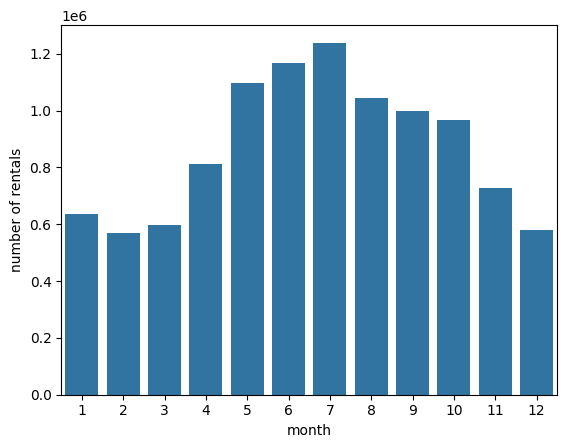

In [10]:
#small test: the number of rental events in the months of a particular year, say 2018
per_month_2018_group = df_london.loc[df_london['year'] == 2018].groupby('month')
month_counts = per_month_2018_group.count()

ax=sns.barplot(x=month_counts.index, y=month_counts.iloc[:,0])
ax.set(ylabel='number of rentals')

<Axes: xlabel='hour'>

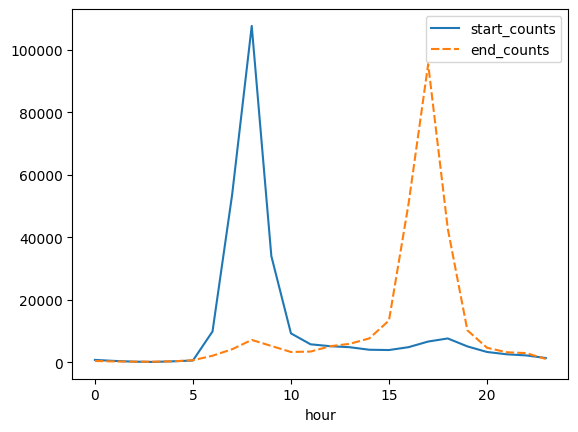

In [11]:
weekday_14_start = df_london.loc[(df_london['start_station_id'] == 14) & (df_london['satsun'] == False)] # only weekdays for station 14
weekday_14_end = df_london.loc[(df_london['end_station_id'] == 14) & (df_london['satsun'] == False)]
weekday_14_start = weekday_14_start.groupby('hour').count()
weekday_14_end = weekday_14_end.groupby('hour').count()
weekday_14_data = pd.DataFrame({'start_counts' : weekday_14_start.iloc[:,0],
                                'end_counts' : weekday_14_end.iloc[:,0]})

sns.lineplot(data=weekday_14_data)

## The analysis

Although we might strongly suspect a correlation between weather and bike usage, I will first plot both their values to see if we see a (rough) correlation. This has still nothing to do with the data-driven part

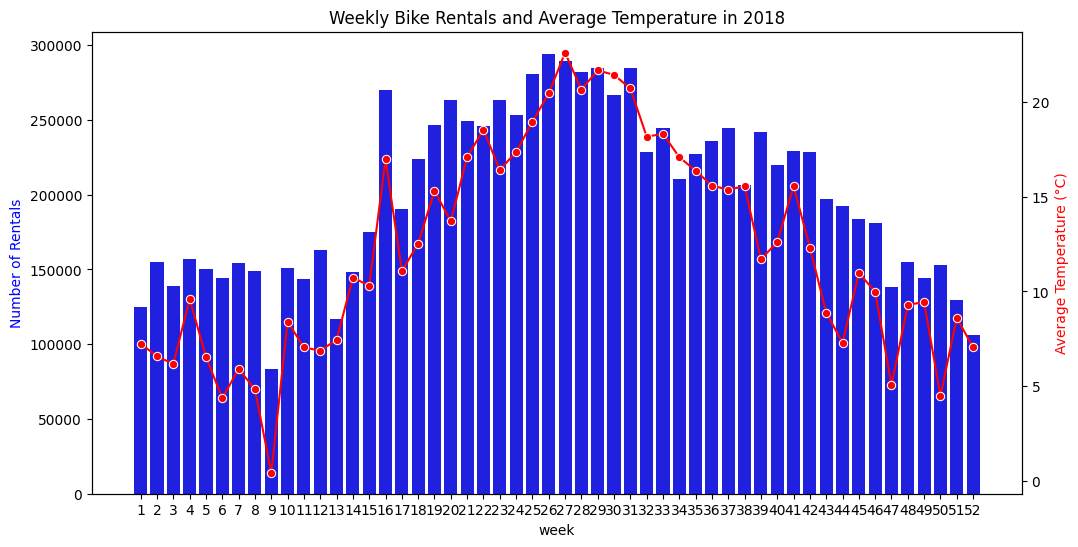

In [12]:
#Let's do it for each week in 2018
#Total number of bike rentals in the week:
per_week_2018_group = df_london.loc[df_london['year'] == 2018].groupby('week')
week_counts = per_week_2018_group.count()

# Compute the average temperature for each whole week of 2018
df_2018 = df_london_weather[df_london_weather['year'] == 2018]
avg_weekly_temp_2018 = df_2018.groupby('week')['tavg'].mean()

#Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.barplot(x=week_counts.index, y=week_counts.iloc[:,0], color='b', ax=ax1)
ax1.set_ylabel('Number of Rentals', color='b')

ax2 = ax1.twinx()
sns.lineplot(x=avg_weekly_temp_2018.index-1, y=avg_weekly_temp_2018, color='r', marker='o', ax=ax2)
ax2.set_ylabel('Average Temperature (°C)', color='r')

plt.title('Weekly Bike Rentals and Average Temperature in 2018')
plt.show()

I think we can conclude that there might definitely be a correlation between the average temperature and the number of bike rentals (clear for example in week 9 and 16)

### Just some ideas: 
We might see all weather-elements of a day as 'variables' and the number of bike-rides of a day as 'output'. We could do a PCA on these?

I don't know if we saw anything of this in class, but you might see all stations as nodes and the bikerides inbetween them as links. This way you can create a graph and show which stations are the most important (I mean from where to where is most driven), there is a kind of example of this in here: https://towardsdatascience.com/london-bike-ride-forecasting-with-graph-convolutional-networks-aee044e48131/

Other ideas are welcome :)